<a href="https://colab.research.google.com/github/aniket2787/PDFtoIMGconverter/blob/master/Handwritten_Text_Recognition_DIGITization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!
!mkdir data
!mkdir data/words
!tar -xf /content/words.tgz -C data/words
!mv /content/words.txt data

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/words’: File exists


In [3]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [4]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [5]:
base_path = "data"
word_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0] == "#":
    continue
  if line.split(" ")[1] != "err":
    word_list.append(line)

len(word_list)
np.random.shuffle(word_list)

In [6]:
split_idx = int(0.9 * len(word_list))
train_samples = word_list[:split_idx]
test_samples = word_list[split_idx:]

val_split_idx = int(0.5* len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(word_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 34474
Total validation samples: 1915
Total test samples: 1916


In [7]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i, file_line) in enumerate(samples):
    line_split  = file_line.strip()
    line_split = line_split.split(" ")


    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI, partI + "-" + partII, image_name + ".png"
    )
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])
  return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)



In [8]:
train_img_paths[0:10]

['data/words/d06/d06-100/d06-100-04-08.png',
 'data/words/a01/a01-026x/a01-026x-07-04.png',
 'data/words/a04/a04-081/a04-081-09-04.png',
 'data/words/b04/b04-195/b04-195-03-02.png',
 'data/words/d07/d07-100/d07-100-09-00.png',
 'data/words/e01/e01-092/e01-092-02-00.png',
 'data/words/a01/a01-026u/a01-026u-05-06.png',
 'data/words/b02/b02-102/b02-102-02-06.png',
 'data/words/b01/b01-073/b01-073-03-04.png',
 'data/words/a01/a01-122u/a01-122u-03-03.png']

In [9]:
# find max length and the size of the vocabulary in the train data
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))


Maximum length:  19
Vocab size:  76


In [10]:

#Check some label samples.
train_labels_cleaned[:20]

['a',
 ',',
 'industry',
 'degree',
 'part',
 'are',
 'parties',
 'of',
 '400',
 '.',
 'is',
 'not',
 'a',
 'any',
 '.',
 'all-Regular',
 'lavish',
 'let',
 "Minister's",
 'would']

In [11]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)



In [12]:
AUTOTUNE =  tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary = list(characters), mask_token = None)

num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert= True)

In [13]:
#Resizing Images without Distortion

In [14]:
def distortion_free_resize(image, img_size):
  w, h = img_size
  image = tf.image.resize(image, size=(h,w), preserve_aspect_ratio=True)

  #Check the amount of padding needed to be done
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  #Only neccessary if you want to do same amount of padding on both the sides
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height + 1
    pad_height_bottom = height

  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
    width = pad_width // 2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width // 2

  image = tf.pad(
      image,
      paddings = [
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0,0]
      ]
  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  return image



In [15]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = distortion_free_resize(image, img_size)
  image = tf.cast(image, tf.float32) / 255
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
  return label

def process_images_labels(image_path, label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
      process_images_labels, num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



In [16]:
#prepare TF.data.Dataset objects
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

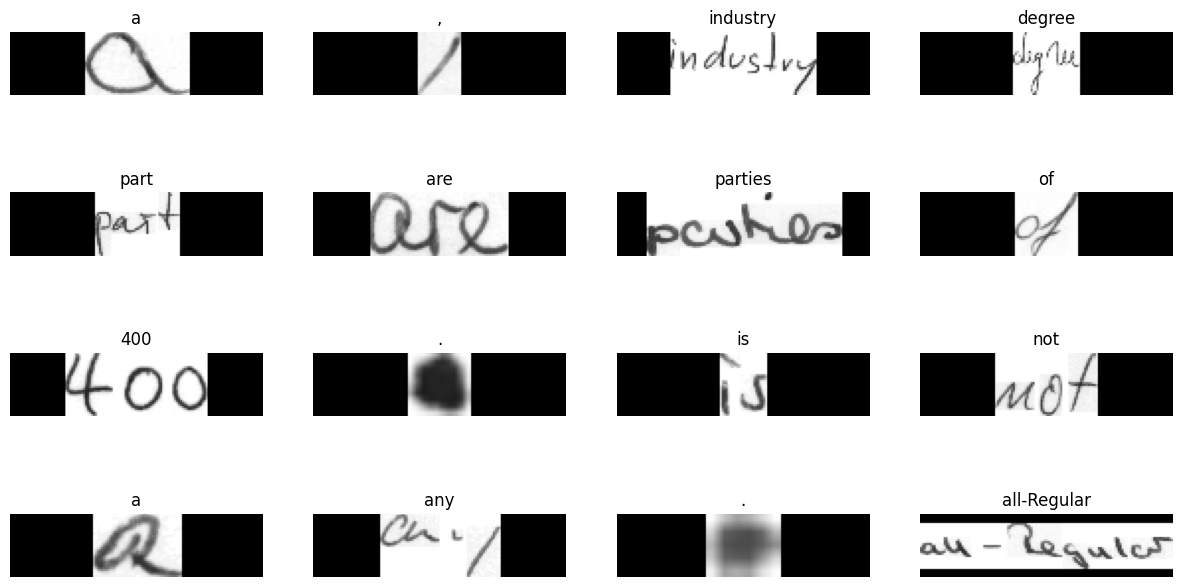

In [17]:
#Visualize a few samples
for data in train_ds.take(1):
  images, labels = data["image"], data["label"]

  _, ax = plt.subplots(4,4,figsize=(15,8))

  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:, :, 0]

    #Gather indices where label!= padding_token.
    label  = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    #convert to String
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")

plt.show()


MODEL

In [18]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred


def build_model():
  # Inputs to the model
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  x = keras.layers.Conv2D(
      32,
      (3,3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Convl",
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  #Second Conv block.
  x = keras.layers.Conv2D(
      64,
      (3,3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = keras.layers.MaxPooling2D((2,2), name="pool2")(x)

  #Reshape
  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name= "reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  #RNNs
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)

  # +2 is to account for the two special tokens introduced by the CTC loss
  x = keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)

  # Add CTC layer for calculating CTC loss at each step
  output = CTCLayer(name="ctc_loss")(labels, x)

  #Define the model
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwritting_recognizer"
  )

  #Optimizer
  opt = keras.optimizers.Adam()

  model.compile(optimizer=opt)
  return model


In [19]:
validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])


In [20]:
def calculate_edit_distance(labels, predictions):
  sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  #input_len = tf.reduce_sum(tf.cast(tf.not_equal(predictions, 0), tf.int32), axis=1)
  predictions_decoded = keras.backend.ctc_decode(
      predictions, input_length = input_len, greedy=True
  )[0][0][:, :max_len]
  sparse_predictions = tf.cast(
      tf.sparse.from_dense(predictions_decoded), dtype= tf.int64
  )

  edit_distances  = tf.edit_distance(
      sparse_predictions, sparse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model

  def on_epoch_end(self, epoch, logs=None):
    edit_distances = []

    for i in range(len(validation_images)):
      labels = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distances.append(calculate_edit_distance(labels, predictions).numpy())


    print(
        f"Mean edit distance for epoch  {epoch + 1}: {np.mean(edit_distances):.4f}"
    )

In [21]:
epochs = 50 # to get good results epoches should be atleast 50
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model
history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = epochs,
    callbacks =  [edit_distance_callback],
)

Epoch 1/50
2/2 [==============================] - 3s 160ms/step
Mean edit distance for epoch  1: 18.8566
539/539 [==============================] - 442s 800ms/step - loss: 15.5485 - val_loss: 13.9521
Epoch 2/50
2/2 [==============================] - 0s 78ms/step
Mean edit distance for epoch  2: 18.5430
539/539 [==============================] - 409s 758ms/step - loss: 13.0947 - val_loss: 12.6746
Epoch 3/50
2/2 [==============================] - 0s 92ms/step
Mean edit distance for epoch  3: 18.3837
539/539 [==============================] - 407s 755ms/step - loss: 12.1161 - val_loss: 11.3121
Epoch 4/50
2/2 [==============================] - 0s 77ms/step
Mean edit distance for epoch  4: 18.1646
539/539 [==============================] - 406s 753ms/step - loss: 10.9854 - val_loss: 10.3678
Epoch 5/50
2/2 [==============================] - 0s 79ms/step
Mean edit distance for epoch  5: 17.9996
539/539 [==============================] - 403s 748ms/step - loss: 10.1006 - val_loss: 9.3128
Epoch

2/2 [==============================] - 0s 102ms/step


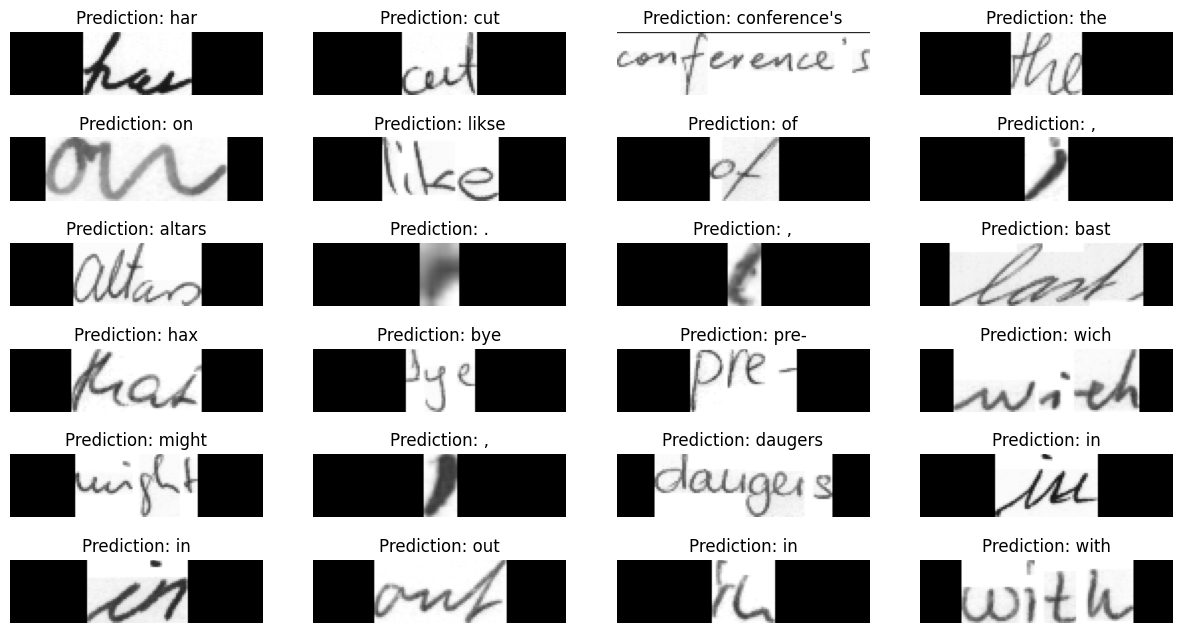

In [29]:
def decode_batch_predictions(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  results = keras.backend.ctc_decode(pred,  input_length=input_len, greedy=True)[0][0][
      :, :max_len
  ]

  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text


# Check the results for some samples
for batch in test_ds.take(1):
  batch_images = batch["image"]
  _, ax = plt.subplots(6,4, figsize=(15,8))

  preds = prediction_model.predict(batch_images)
  pred_texts  = decode_batch_predictions(preds)

  for i in range(24):
    img = batch_images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")


plt.show()
